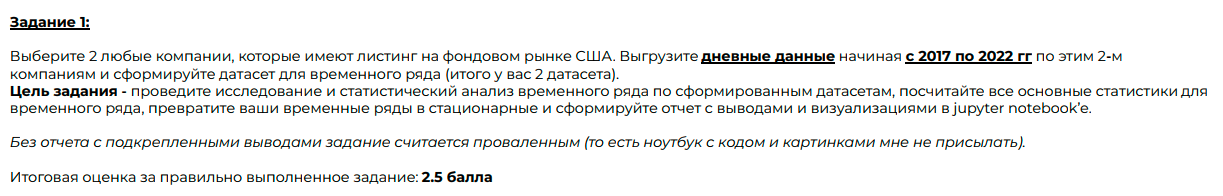

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
!pip install --upgrade mplfinance
from mplfinance.original_flavor import candlestick_ohlc
!pip install yfinance
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import scipy
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install watermark --quiet
%load_ext watermark
%watermark -a 'Anrei Sech' -v

Author: Anrei Sech

Python implementation: CPython
Python version       : 3.7.15
IPython version      : 7.9.0



# Get data

Для загрузки финансовых данных воспользуемся сервисом от Yahoo Finance (yfinance). Возьмем 2 комании из списка активно торгуемых на финансовом рынке США (https://finance.yahoo.com/most-active):
AMZN - Amazon.com, Inc.
F - Ford Motor Company

In [ ]:
def get_price_data(ticker):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2022-10-1')
    return tickerDf.iloc[:, :5]

In [ ]:
amazon_df = get_price_data('AMZN')

In [ ]:
amazon_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03 00:00:00-05:00,37.896000,37.938000,37.384998,37.683498,70422000
2017-01-04 00:00:00-05:00,37.919498,37.984001,37.709999,37.859001,50210000
2017-01-05 00:00:00-05:00,38.077499,39.119999,38.013000,39.022499,116602000
2017-01-06 00:00:00-05:00,39.118000,39.972000,38.924000,39.799500,119724000
2017-01-09 00:00:00-05:00,39.900002,40.088501,39.588501,39.846001,68922000


Как видим данные уже представлены в подходящем формате. Дата вынесена как и индекс, что упрощает операции для последующего анализа представленных данных. Дополнительный препроцессинг не требуется, за исключением того, что стоит явно указать на то, что данные ежедневные (every business day). 
В представленных данных нас интересует в первую очередь цена закрытия (close).

In [ ]:
amazon_df.index.Freq = 'B'

Самый простой вариант вывести основные статистичские характеристики dataframe - используя стандартный метод в pandas:

In [ ]:
amazon_df['Close'].describe()

count    1447.000000
mean      108.342106
std        42.833491
min        37.683498
25%        79.410000
50%        95.213997
75%       155.211250
max       186.570496
Name: Close, dtype: float64

Итак, средняя цена акций компании Amazon (математическое ожидание) за указанный период составила 108.3 USD, но при этом варьировалась в широких пределах от 37.7 USD до 186.6 USD. Среднеквадратическое отклонение составило 42.8 при значении I (нижнего) и III (верхнего) квартилей 79.4 и 155.2. Межквартильный размах составил 75.8, или 70% от среднего значения

In [ ]:
ford_df = get_price_data('F')

In [ ]:
ford_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03 00:00:00-05:00,9.676392,9.993651,9.620872,9.985720,40510800
2017-01-04 00:00:00-05:00,10.128489,10.525062,10.104694,10.445747,77638100
2017-01-05 00:00:00-05:00,10.477472,10.485404,10.017447,10.128488,75628400
2017-01-06 00:00:00-05:00,10.152282,10.184008,10.025378,10.120556,40315900
2017-01-09 00:00:00-05:00,10.144352,10.199872,10.017448,10.017448,39438400


In [ ]:
ford_df.index.Freq = 'B'

In [ ]:
ford_df['Close'].describe()

count    1447.000000
mean       10.358028
std         3.430422
min         3.904326
25%         8.439665
50%         9.389077
75%        11.820078
max        24.649670
Name: Close, dtype: float64

В номинальном выражении цена акций Ford ниже цены акций Amazon примерно в 10 раз, но также была значительно волатильной. При среднем значении в 10.4 USD среднеквадратическое отклонение составило 3.4 USD. В целом она изменялась в диапазоне от 3.9 до 24.6 USD, при этом половина наблюдаемых значений цены находилась в диапазоне 8.4-11.8 USD. Межвартильный размах составил 3.4 USD, или 33% от средней цены.
В целом, если можно судить на примере только одной компании, автомобильный рынок оказался более стабильным, чем рынок розничной торговли.

Визуализируем графики для оценки динамики:

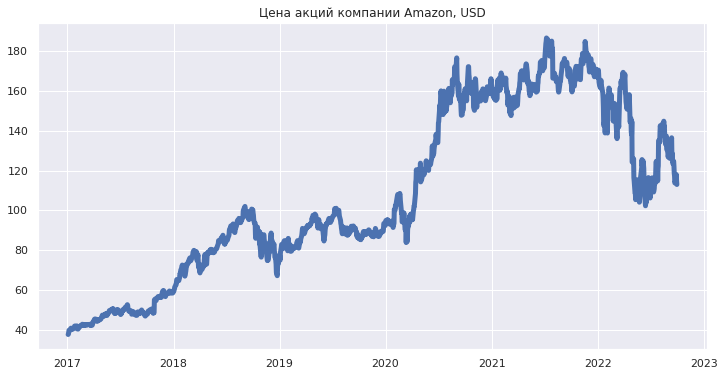

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(amazon_df['Close'], linewidth=5.0)
plt.title('Цена акций компании Amazon, USD')
plt.show()

В целом можно увидить значительный восходящий долгосрочный тренд. Причем даже во время эпидемии короновируса, который негативно в целом повлиял на экономическую ситуации и финансовые показатели большинства компании, для крупной организации интернет-торговли, как Amazon, он скорее оказал положительное влияние на финансовую деятельность: в условиях изоляции покупатели все чаще прибегали к услагам интернет-торговли с доставкой товаров на дом, чем пользовались услами традиционных торговых центров и магазинов розничной торговли. При этом в текущем году все же ввиду неблагоприятной ситуации цена акции значительно "просела". Это можем видеть на графике "свечей" ниже. Более длинные красные нисходящие свечи в текущем году наблюдаются чаще на графика цены акций.

In [ ]:
def plot_candlestick(df, ax=None, fmt="%Y-%m-%d"):
    if ax is None:
        fig, ax = plt.subplots()
    idx_name = df.index.name if df.index.name else 'index'
    dat = df.reset_index()[[idx_name, "Open", "High", "Low", "Close"]]
    dat[idx_name] = dat[idx_name].map(mdates.date2num)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
    plt.xticks(rotation=45)
    _ = candlestick_ohlc(ax, dat.values, width=.6, colorup='g', alpha =1)
    ax.set_xlabel(idx_name)
    ax.set_ylabel("OHLC")
    return ax

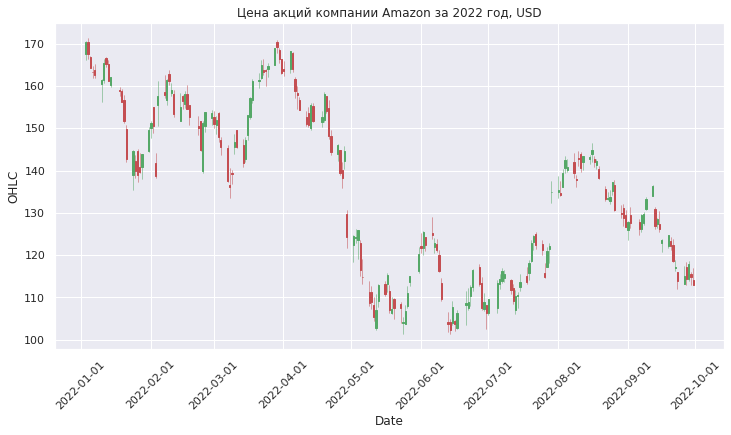

In [ ]:
fig = plt.figure(figsize=(12,6))
plot_candlestick(amazon_df['2022-1-1':], fig.subplots())
plt.title('Цена акций компании Amazon за 2022 год, USD')
plt.show()

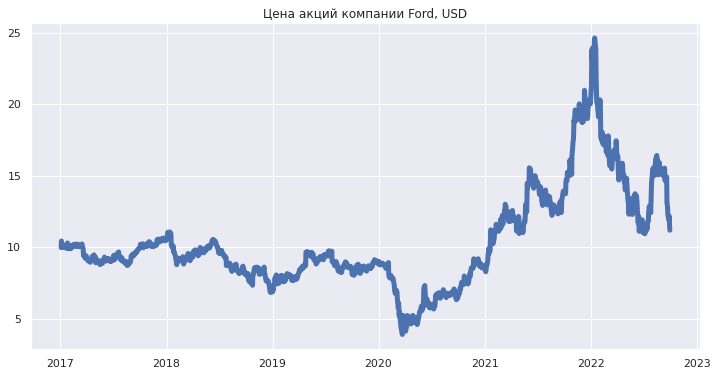

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(ford_df['Close'], linewidth=5.0)
plt.title('Цена акций компании Ford, USD')
plt.show()

Как видим на примере Ford автомобильный рынок из-за пандемии значительно просел, что вполне логично, учитывая резкое сокращение возможности передвижений в этот период, но затем начался восстановительный рост, превысивший докризисный период. Впрочем, 2022 год оказался богат на негативные потрясения, в частности из-за этого наблюдается стремительный рост цен на энергоносители и нефтепродукты, что как и в случае с Amazon также повлияло на падение акций в текущем году (более выражено видно на графике "свечей" ниже)

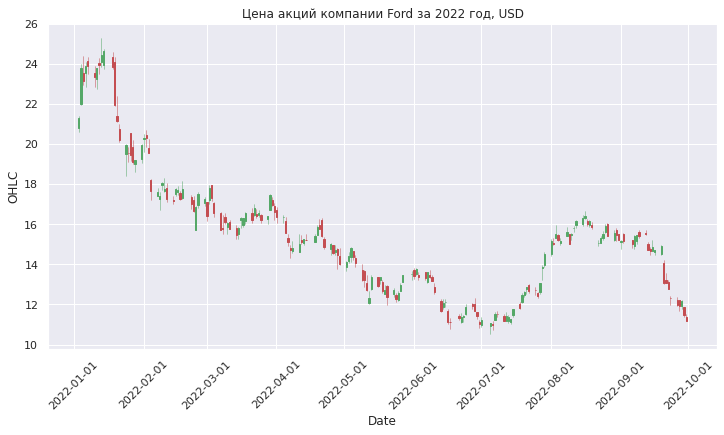

In [ ]:
fig = plt.figure(figsize=(12,6))
plot_candlestick(ford_df['2022-1-1':], fig.subplots())
plt.title('Цена акций компании Ford за 2022 год, USD')
plt.show()

В целом на коротком промежутке времени графики цен напоминают случайное блуждание, однако на долгосрочном отчетливо проявляются периоды в которых видны тренды и развороты этих трендов, вызванные по-видиму внешними (экзогенными) шоками.

Сравним между собой данные два графика. Но для того, чтобы это сделать, надо их нормировать, т.е. привести к одному масштабу в начальной точке

In [ ]:
closing_prices = pd.concat([amazon_df['Close'], ford_df['Close']], keys=['Amazon', 'Ford'], axis=1)
closing_prices.head()

,Amazon,Ford
Date,,
2017-01-03 00:00:00-05:00,37.683498,9.985720
2017-01-04 00:00:00-05:00,37.859001,10.445747
2017-01-05 00:00:00-05:00,39.022499,10.128488
2017-01-06 00:00:00-05:00,39.799500,10.120556
2017-01-09 00:00:00-05:00,39.846001,10.017448


In [ ]:
closing_prices['Amazon_n'] = closing_prices['Amazon'] / closing_prices['Amazon'].iloc[0]
closing_prices['Ford_n'] = closing_prices['Ford'] / closing_prices['Ford'].iloc[0]

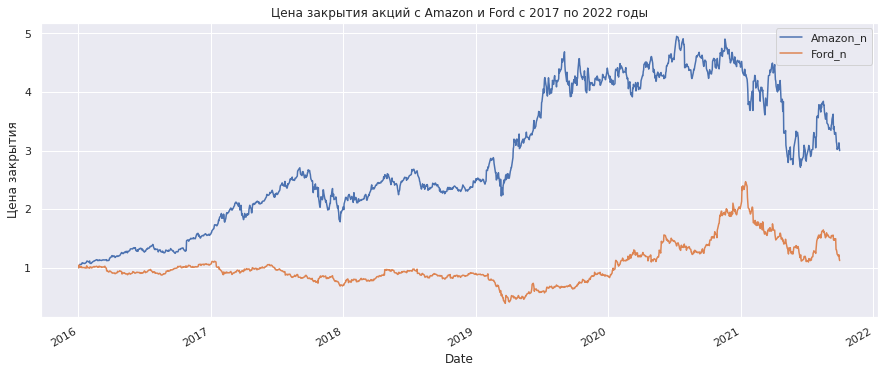

In [ ]:
plot = closing_prices[['Amazon_n', 'Ford_n']].plot(
    title=f'Цена закрытия акций с Amazon и Ford с 2017 по 2022 годы',
    ylabel="Цена закрытия", figsize=(15, 6))

Как видим, вложить деньги в акции компании Amazon в указанном периоде было бы выгоднее: цены ее акций продемонстрировали гораздо более значительный рост, что обеспечило бы гораздо большую отдачу на вложенный капитал.

В целях анализа временных рядов выполним их декомпозицию, воспользуясь станадартной библиотекой для статистических исследований statsmodels. Декомпозиция может быть выполнена двумя методами (моделями): аддитивная и мультипликативная. Для случая анализа эконометрических данных исходя из их природы нам больше подходит мультипликативная модель: сумма получаемого экономического эффекта при примерно той же эффективность пропорциональна наличию имеющихся ресурсов.

In [ ]:
amazon_close = amazon_df['Close'].asfreq('D').fillna(method="bfill")
amazon_decomposed = seasonal_decompose(amazon_close, model='multiplicative')

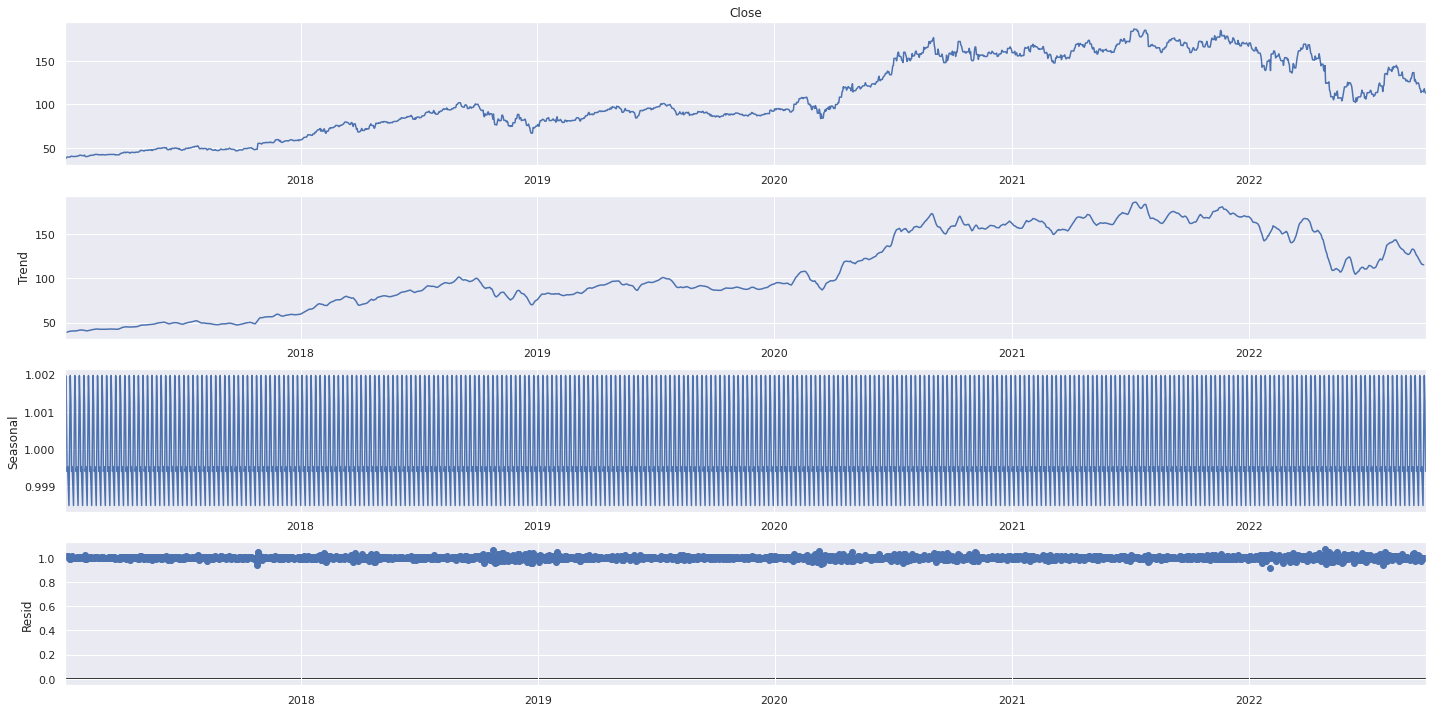

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
plot = amazon_decomposed.plot()

In [ ]:
ford_close = ford_df['Close'].asfreq('D').fillna(method="bfill")
ford_decomposed = seasonal_decompose(ford_close, model='multiplicative')

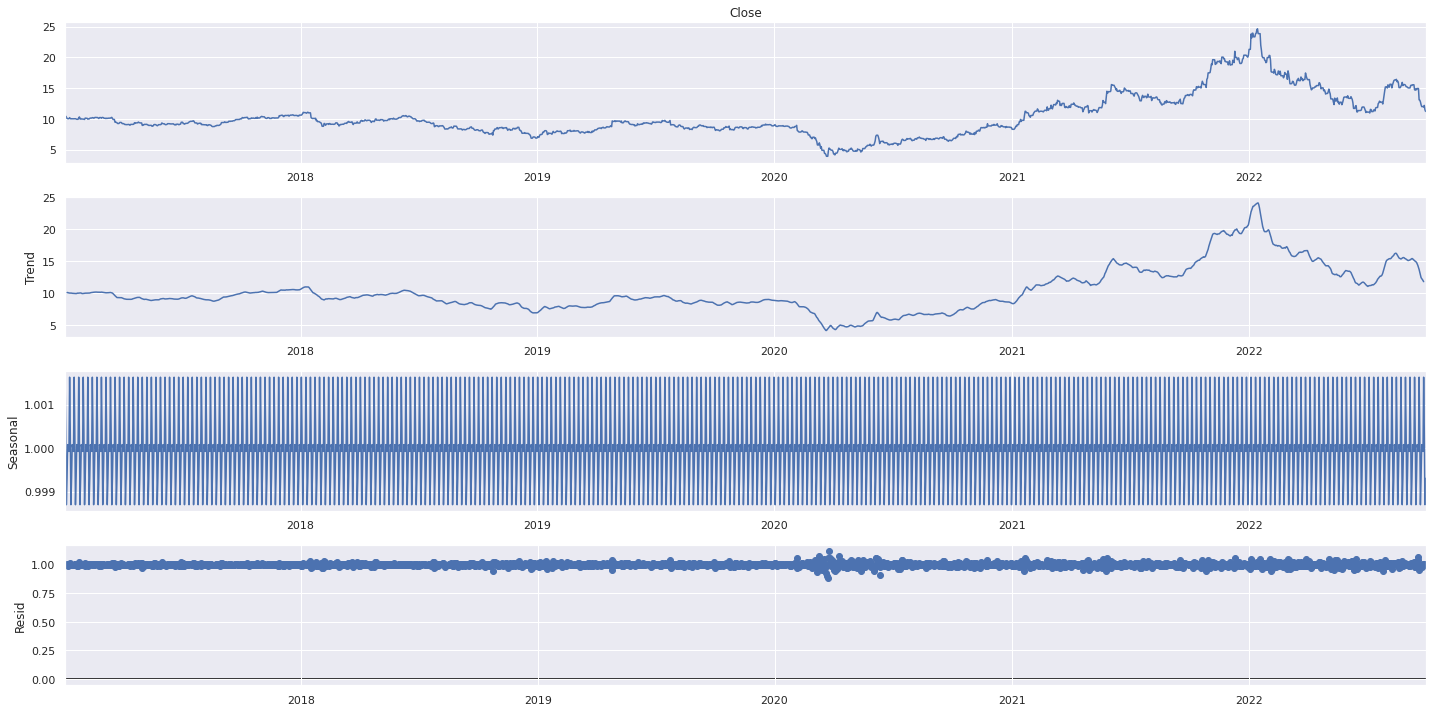

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
plot = ford_decomposed.plot()

В нашем случае нет отчетливо выраженной сезонной компоненты, поэтому такое разложение дает сомнительный результат: в основном все движение объясняется наличием тренда. Сезонная компонетна в данном случае убирает краткосрочные высокочастотные колебания. При этом остатки не соотвествуют требованию гомоскедантичности, так что качество такого разложения выглядит сомнительным и малопригодным для анализа.

Проанализуем авторегрессионные компоненты и проверим данные временные ряды на стационарность. В целом визуально видно, что ряды не стационарные в нашем случае, однако для большей объективности и для получения количественной оценки стационарности/нестационарности воспользуемся статистическим тестом Дики-Фуллера (Dickey-Fuller Test)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, zero=False)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, zero=False)
        plt.tight_layout()

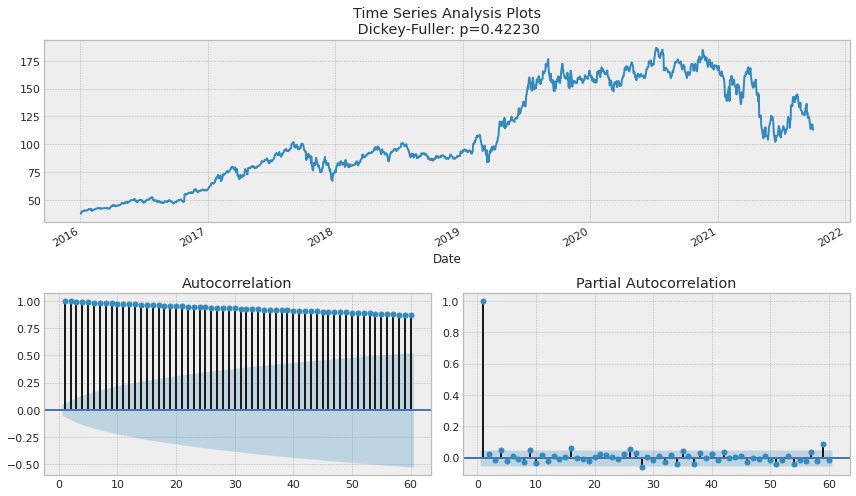

In [ ]:
tsplot(amazon_df['Close'], lags=60)

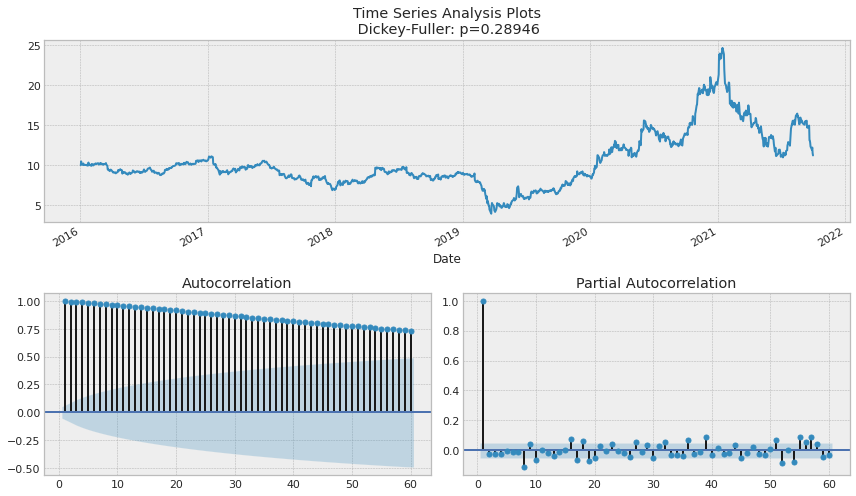

In [ ]:
tsplot(ford_df['Close'], lags=60)

Временные ряды акций Amazon и Ford ведут себя схожим образом, так что далее можно сделать некоторые общие выводы, справедливые для обоих.

Нижние 2 графика иллюстрируют наличие автокорреляции и частичной автокорреляции, т.е. в какой степени значение цены в момент времени t определяется (коррелирует) со значение в момент времени t - τ (лаг). Как видим из графика автокорреляции в наибольшей степени значение цены определяется значением в предшествующий момент времени, затем это влияние с удалением во времени постепенно снижается. Отличие автокорреляции от частичной автокорреляции заключается в учете косвенного влияния, когда значение в момент времени t-2 влияет на значение в t-1, а через него на значение в момент t. Если очистить от такого косвенного влияния и оценить только прямое влияние (график частичной автокорреляции), то можно увидеть, что велико влияние предшествующего момента времени, а остальные прошлые периоды с лагом более 1 не оказывают статистически значенимого влияния на значение в текущий момент. Отсутствие характерного пика на графике частичной автокорреляции означает, что выраженная сезонность отсутствует.

Также на графике отражено значение посчитанной статистики теста Дика-Фуллера. Гипотеза H0 определяется как то, что ряд нестационарный. Если полученное значение меньше 0.05 (традиционно выбирается в качестве уровня значимости, при номральном распределение 95% значений лежит в диапазоне μ +- 2 * σ ), тогда отвергается гипотеза о нестационарности ряда, ряд стационарен, если расчитанное значение выше 0.05, как в нашем случае - ряд нестационарен.

Стационарность ряда очень важно для улучшения качества модели, так что приведем данные ряды к стационарному виду путем преобразований исходного ряда. Применим несколько видов трансформаций: извлечение квадратного корня, дифференцирование и boxcox-транформация. Последняя считается по формуле:

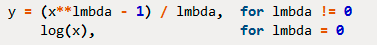

In [ ]:
def show_histplots(time_series):
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    sns.set(style="darkgrid")

    fig, axs = plt.subplots(2, 2, figsize=(7, 7))

    p_value_original = sm.tsa.stattools.adfuller(time_series['original'])[1]    
    p_value_sqrt = sm.tsa.stattools.adfuller(time_series['sqrt'])[1]
    p_value_log = sm.tsa.stattools.adfuller(time_series['log'])[1]
    p_value_boxcox = sm.tsa.stattools.adfuller(time_series['boxcox'])[1]
    

    sns.histplot(data=time_series, x='original', kde=True, color="skyblue", ax=axs[0, 0])
    sns.histplot(data=time_series, x='sqrt', kde=True, color="olive", ax=axs[0, 1])
    sns.histplot(data=time_series, x='log', kde=True, color="gold", ax=axs[1, 0])
    sns.histplot(data=time_series, x='boxcox', kde=True, color="teal", ax=axs[1, 1])

    print('----------------------------------------')
    print(f'Original time series p-value: {p_value_boxcox}')
    print(f'Log p-value: {p_value_log}')
    print(f'Sqrt p-value: {p_value_sqrt}')
    print(f'BoxCox p-value: {p_value_original}')
    print('----------------------------------------')

    plt.show()

In [ ]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
def apply_transformations(df_column):
    ts = pd.DataFrame()
    ts['original'] = df_column
    ts['sqrt'] = np.sqrt(ts['original'])
    ts['log'] = np.log(ts['original'])
    data, lambda_power = scipy.stats.boxcox(ts['original'])
    ts['boxcox'] = data
    return ts

----------------------------------------
Original time series p-value: 0.334194079304619
Log p-value: 0.23723872018539893
Sqrt p-value: 0.32761023230729946
BoxCox p-value: 0.4222954959160005
----------------------------------------


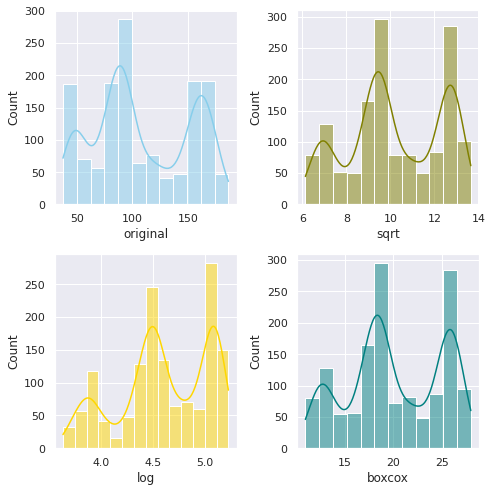

In [ ]:
ts = apply_transformations(amazon_df['Close'])
show_histplots(ts)

Имеет место мультимодальное распределение, которое не становится похожим на нормальное даже после данных трансформаций. Тест Дика-Фуллера показывает, что преобразованные временные ряды также нестационарны.

----------------------------------------
Original time series p-value: 0.3636288490059737
Log p-value: 0.4123977212676222
Sqrt p-value: 0.432207106040961
BoxCox p-value: 0.2894635376629362
----------------------------------------


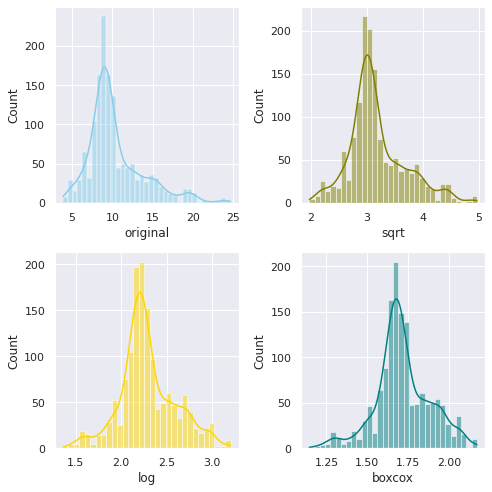

In [ ]:
ts = apply_transformations(ford_df['Close'])
show_histplots(ts)

В этом случае распределение унимодальное, гораздо ближе к нормальному, особенно после трансформаций. Однако временные ряды все еще не становятся стационарными после преобразований.

Для преобразования к стационарности воспользуемся дифференцированием:

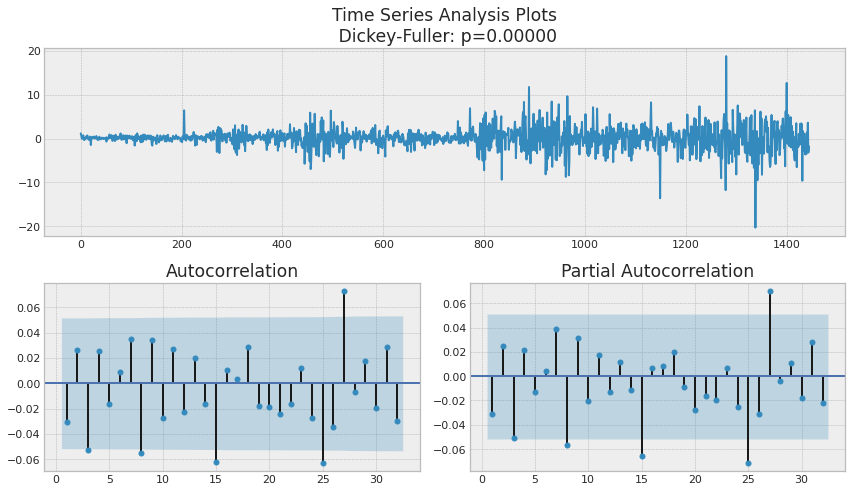

In [ ]:
series = np.diff(amazon_df['Close'], 1)
tsplot(series[1:])

In [ ]:
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                  -22.881152
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    1443.000000
Critical Value (1%)              -3.434890
Critical Value (5%)              -2.863545
Critical Value (10%)             -2.567837
dtype: float64


Есть некоторый рост дисперсии со временем, однако такой преобразованный ряд согласно статистике Дика-Фуллера уже является стационарным

Проделаем дифференцирование также для цены акций Ford

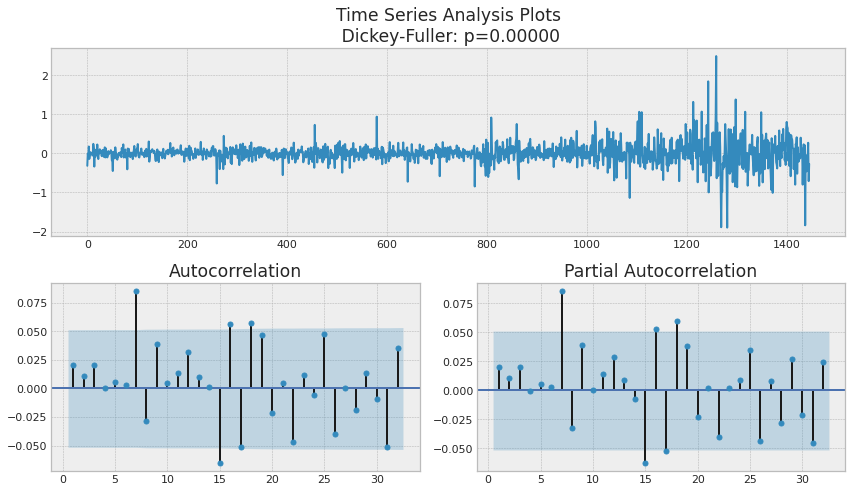

In [ ]:
series = np.diff(ford_df['Close'], 1)
tsplot(series[1:])

В результате, как и в предыдущем случае, получен стационарный ряд.

In [ ]:
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                -7.261704e+00
p-value                        1.674951e-10
#Lags Used                     1.800000e+01
Number of Observations Used    1.427000e+03
Critical Value (1%)           -3.434941e+00
Critical Value (5%)           -2.863568e+00
Critical Value (10%)          -2.567849e+00
dtype: float64
